In [3]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import marsilea as ma
import marsilea.plotter as mp
from adjustText import adjust_text
import scienceplots
# %matplotlib widget
import pickle
plt.style.use(['science', 'nature'])
import numpy as np
from itertools import combinations, product

In [4]:
tool_map = {
    "scapa": "scAPA",
    "scapatrap": "scAPAtrap",
    "sierra": "Sierra",
    "maaper": "MAAPER",
    "scapture": "SCAPTURE",
    "scape": "SCAPE",
    "infernape": "Infernape",
}

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
}

protocol_order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
tool_order = ["SCAPE", "scAPAtrap", "Infernape", "SCAPTURE", "scAPA",  "Sierra"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]

palette=sns.color_palette(color, 7)
mm = 1/25.4

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["legend.title_fontsize"] = 6
plt.rcParams['hatch.linewidth'] = 0.5

In [5]:
de_performance_df = pd.read_csv('/root/apabenchmark/data/performance/de_apa_performance.tsv', sep='\t')
de_performance_df["protocol"] = de_performance_df["protocol"].map(protocol_map)
de_performance_df["tool"] = de_performance_df["tool"].map(tool_map)
de_performance_df["protocol"] = pd.Categorical(de_performance_df["protocol"], categories=protocol_order)
de_performance_df["tool"] = pd.Categorical(de_performance_df["tool"], categories=tool_order)
de_performance_df = de_performance_df[de_performance_df["filter_type_1"].str.endswith("0.05")]

filter_type_2_list = [
    "PDUI_0.2",
    "PPUI_0.2",
    "RWUI_0.1",
    "DWUI_0.1",
    "MPRO_0.2",
    "dexseq_log2fc_0.5"
]
de_performance_filtered_df = de_performance_df[de_performance_df["filter_type_2"].isin(filter_type_2_list)]

In [6]:
de_performance_max_f1_df = (de_performance_filtered_df
                         .groupby(['tool', 'sample'])
                         .apply(lambda x: x.sort_values('f1', ascending=False).head(1))
                         .reset_index(drop=True)
                         .groupby(['tool', 'protocol'])
                         .mean(numeric_only=True)
                         .reset_index()
                         .pivot(index='tool', columns='protocol', values='f1')
                         )

de_performance_max_precision_df = (de_performance_filtered_df
                         .groupby(['tool', 'sample'])
                         .apply(lambda x: x.sort_values('f1', ascending=False).head(1))
                         .reset_index(drop=True)
                         .groupby(['tool', 'protocol'])
                         .mean(numeric_only=True)
                         .reset_index()
                         .pivot(index='tool', columns='protocol', values='precision')
                         )

de_performance_max_recall_df = (de_performance_filtered_df
                         .groupby(['tool', 'sample'])
                         .apply(lambda x: x.sort_values('f1', ascending=False).head(1))
                         .reset_index(drop=True)
                         .groupby(['tool', 'protocol'])
                         .mean(numeric_only=True)
                         .reset_index()
                         .pivot(index='tool', columns='protocol', values='recall')
                         )

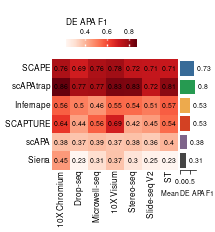

In [61]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = ["Reds", "Blues", "Greens"]
h = ma.Heatmap(
    de_performance_max_f1_df,
    cmap=cmap[0],
    label="DE APA F1",
    width=32*mm,
    height=28*mm,
    cbar_kws={"orientation": "horizontal","width":10, "height":1},
)
h.add_layer(mp.TextMesh(np.around(de_performance_max_f1_df.to_numpy(),2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    de_performance_max_f1_df.mean(axis=1).to_numpy().round(2),
    color=palette[0:6][::-1], 
    label="Mean DE APA F1",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=4*mm,
    pad=0.5*mm
)
# h.add_top(mp.Numbers(
#     de_performance_max_f1_df.mean().round(2),
#     color=palette, 
#     label="Mean DE APA F1",
#     show_value=True,
#     props={"fontsize": 5}
#     ),
#     size=4*mm,
#     pad=1*mm,
#     name="top"
# )


# h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)
h.add_left(mp.Labels(tool_order, rotation=0, fontsize=6), size=7*mm, pad=0.5*mm)
# h.add_bottom(mp.Chunk(["" for i in range(7)], palette),pad=0.05)
h.add_bottom(mp.Labels(protocol_order, rotation=90, fontsize=6), size=10*mm, pad=0.5*mm)
h.add_legends("top")
h.render()

# h.get_ax("top").yaxis.set_label_position("right")
# h.get_ax("top").yaxis.set_ticks_position("right")
# h.get_ax("top").tick_params(axis='y', which='minor', right=False)
# h.get_ax("top").spines["right"].set_visible(True)
# h.get_ax("top").spines["left"].set_visible(False)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_f1.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

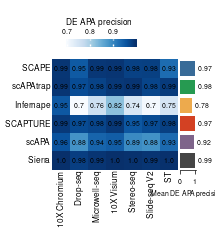

In [59]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = ["Reds", "Blues", "Greens"]
h = ma.Heatmap(
    de_performance_max_precision_df,
    cmap=cmap[1],
    label="DE APA precision",
    width=32*mm,
    height=28*mm,
    cbar_kws={"orientation": "horizontal","width":10, "height":1},

)
h.add_layer(mp.TextMesh(np.around(de_performance_max_precision_df.to_numpy(),2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    de_performance_max_precision_df.mean(axis=1).to_numpy().round(2),
    color=palette[0:6][::-1], 
    label="Mean DE APA precision",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=4*mm,
    pad=0.5*mm
)
# h.add_top(mp.Numbers(
#     de_performance_max_precision_df.mean().round(2),
#     color=palette, 
#     label="Mean DE APA precision",
#     show_value=True,
#     props={"fontsize": 5}
#     ),
#     size=4*mm,
#     pad=1*mm,
#     name="top"
# )


# h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)
h.add_left(mp.Labels(tool_order, rotation=0, fontsize=6), size=7*mm, pad=0.5*mm)
# h.add_bottom(mp.Chunk(["" for i in range(7)], palette),pad=0.05)
h.add_bottom(mp.Labels(protocol_order, rotation=90, fontsize=6), size=10*mm, pad=0.5*mm)
h.add_legends("top")
h.render()

# h.get_ax("top").yaxis.set_label_position("right")
# h.get_ax("top").yaxis.set_ticks_position("right")
# h.get_ax("top").tick_params(axis='y', which='minor', right=False)
# h.get_ax("top").spines["right"].set_visible(True)
# h.get_ax("top").spines["left"].set_visible(False)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_precision.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

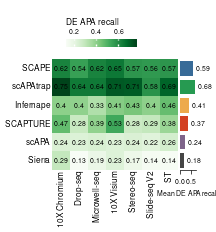

In [58]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = ["Reds", "Blues", "Greens"]
h = ma.Heatmap(
    de_performance_max_recall_df,
    cmap="Greens",
    label="DE APA recall",
    width=32*mm,
    height=28*mm,
    cbar_kws={"orientation": "horizontal","width":10, "height":1},
)
h.add_layer(mp.TextMesh(np.around(de_performance_max_recall_df.to_numpy(),2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    de_performance_max_recall_df.mean(axis=1).to_numpy().round(2),
    color=palette[0:6][::-1], 
    label="Mean DE APA recall",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=4*mm,
    pad=0.5*mm
)
# h.add_top(mp.Numbers(
#     de_performance_max_recall_df.mean().round(2),
#     color=palette, 
#     label="Mean DE APA recall",
#     show_value=True,
#     props={"fontsize": 5},
#     ),
#     size=4*mm,
#     pad=1*mm,
#     name="top"
# )


# h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)
h.add_left(mp.Labels(tool_order, rotation=0, fontsize=6), size=7*mm, pad=0.5*mm)
# h.add_bottom(mp.Chunk(["" for i in range(7)], palette),pad=0.05)
h.add_bottom(mp.Labels(protocol_order, rotation=90, fontsize=6), size=10*mm, pad=0.5*mm)
h.add_legends("top")
h.render()

# h.get_ax("top").yaxis.set_label_position("right")
# h.get_ax("top").yaxis.set_ticks_position("right")
# h.get_ax("top").tick_params(axis='y', which='minor', right=False)
# h.get_ax("top").spines["right"].set_visible(True)
# h.get_ax("top").spines["left"].set_visible(False)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_recall.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

/tmp/ipykernel_845783/3970881050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_performance_filtered_df["rank"] = de_performance_filtered_df.groupby(["sample", "tool"])["f1"].transform(lambda x: x.rank(ascending=False))


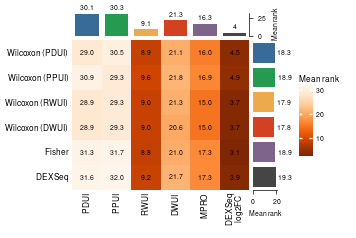

In [8]:
de_performance_filtered_df["rank"] = de_performance_filtered_df.groupby(["sample", "tool"])["f1"].transform(lambda x: x.rank(ascending=False))
de_performance_filter_rank = (de_performance_filtered_df
                              .groupby(["filter_type_1", "filter_type_2"])
                              .mean(numeric_only=True)
                              .reset_index()
                              )

filter_type_1_list = [
    'wilcox_DWUI_0.05',
    'wilcox_PDUI_0.05',
    'wilcox_PPUI_0.05',
    'wilcox_RWUI_0.05',
    'fisher_0.05',
    'dexseq_0.05',
]
filter_type_2_list = [
    'MPRO_0.2',
    'DWUI_0.1',
    'PDUI_0.2',
    'PPUI_0.2',
    'RWUI_0.1',
    'dexseq_log2fc_0.5'
    ]

de_performance_filter_rank = de_performance_filter_rank[de_performance_filter_rank["filter_type_1"].isin(filter_type_1_list)]
# de_performance_filter_rank = de_performance_filter_rank[de_performance_filter_rank["filter_type_2"].isin(filter_type_2_list)]

filter_type_1_map = {
    'wilcox_PDUI_0.05': 'PDUI',
    'wilcox_PPUI_0.05': 'PPUI',
    'wilcox_DWUI_0.05': 'DWUI',
    'wilcox_RWUI_0.05': 'RWUI',
    'fisher_0.05': 'Fisher',
    'dexseq_0.05': 'DEXSeq',
}
filter_type_2_map = {
    'MPRO_0.2': 'MPRO',
    'DWUI_0.1': 'DWUI',
    'PDUI_0.2': 'PDUI',
    'PPUI_0.2': 'PPUI',
    'RWUI_0.1': 'RWUI',
    'dexseq_log2fc_0.5': 'DEXSeq log2FC',
}

filter_type_1_order = ['PDUI', 'PPUI', 'RWUI', 'DWUI', 'Fisher', 'DEXSeq']
filter_type_2_order = ['PDUI', 'PPUI', 'RWUI', 'DWUI',  'MPRO', 'DEXSeq log2FC']
filter_type_1_label = ['Wilcoxon (PDUI)','Wilcoxon (PPUI)','Wilcoxon (RWUI)','Wilcoxon (DWUI)','Fisher','DEXSeq']
filter_type_2_label = ['PDUI', 'PPUI', 'RWUI', 'DWUI', 'MPRO', 'DEXSeq \nlog2FC']

de_performance_filter_rank["filter_type_1"] = de_performance_filter_rank["filter_type_1"].map(filter_type_1_map)
de_performance_filter_rank["filter_type_2"] = de_performance_filter_rank["filter_type_2"].map(filter_type_2_map)
de_performance_filter_rank["filter_type_1"] = pd.Categorical(de_performance_filter_rank["filter_type_1"], categories=filter_type_1_order)
de_performance_filter_rank["filter_type_2"] = pd.Categorical(de_performance_filter_rank["filter_type_2"], categories=filter_type_2_order)
de_performance_filter_rank = de_performance_filter_rank.pivot(index='filter_type_1', columns='filter_type_2', values='rank')

plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = ["Reds", "Blues", "Greens"]
h = ma.Heatmap(
    de_performance_filter_rank,
    cmap="Oranges_r",
    label="Mean rank",
    width=45*mm,
    height=38*mm,
)
h.add_layer(mp.TextMesh(np.around(de_performance_filter_rank.to_numpy(),1), color="black", fontsize=5))

h.add_right(mp.Numbers(
    de_performance_filter_rank.mean(axis=1).to_numpy().round(1),
    color=palette[0:6][::-1], 
    label="Mean rank",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=6*mm,
    pad=1*mm
)
h.add_top(mp.Numbers(
    de_performance_filter_rank.mean().round(1),
    color=palette, 
    label="Mean rank",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=6*mm,
    pad=1*mm,
    name="top"

)


# h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)

h.add_legends("right", align_legends="top",pad=2*mm)
# h.cut_cols([4,5], spacing=0.5*mm)
# h.cut_rows([4,5], spacing=0.5*mm)
h.add_left(mp.Labels(filter_type_1_label, rotation=0, fontsize=6), size=7*mm, pad=1*mm)
h.add_bottom(mp.Labels(filter_type_2_label, rotation=90, fontsize=6), size=10*mm, pad=1*mm)
h.render()

h.get_ax("top").yaxis.set_label_position("right")
h.get_ax("top").yaxis.set_ticks_position("right")
h.get_ax("top").tick_params(axis='y', which='minor', right=False)
h.get_ax("top").spines["right"].set_visible(True)
h.get_ax("top").spines["left"].set_visible(False)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_f1_rank.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

/tmp/ipykernel_845783/2849401734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_performance_filtered_df["rank"] = de_performance_filtered_df.groupby(["sample", "tool"])["precision"].transform(lambda x: x.rank(ascending=False))


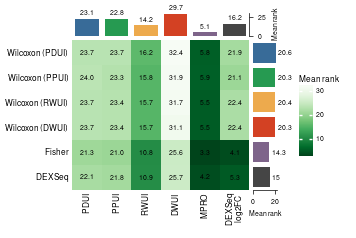

In [9]:
de_performance_filtered_df["rank"] = de_performance_filtered_df.groupby(["sample", "tool"])["precision"].transform(lambda x: x.rank(ascending=False))
de_performance_filter_rank = (de_performance_filtered_df
                              .groupby(["filter_type_1", "filter_type_2"])
                              .mean(numeric_only=True)
                              .reset_index()
                              )

filter_type_1_list = [
    'wilcox_DWUI_0.05',
    'wilcox_PDUI_0.05',
    'wilcox_PPUI_0.05',
    'wilcox_RWUI_0.05',
    'fisher_0.05',
    'dexseq_0.05',
]
filter_type_2_list = [
    'MPRO_0.2',
    'DWUI_0.1',
    'PDUI_0.2',
    'PPUI_0.2',
    'RWUI_0.1',
    'dexseq_log2fc_0.5'
    ]

de_performance_filter_rank = de_performance_filter_rank[de_performance_filter_rank["filter_type_1"].isin(filter_type_1_list)]
# de_performance_filter_rank = de_performance_filter_rank[de_performance_filter_rank["filter_type_2"].isin(filter_type_2_list)]

filter_type_1_map = {
    'wilcox_PDUI_0.05': 'PDUI',
    'wilcox_PPUI_0.05': 'PPUI',
    'wilcox_DWUI_0.05': 'DWUI',
    'wilcox_RWUI_0.05': 'RWUI',
    'fisher_0.05': 'Fisher',
    'dexseq_0.05': 'DEXSeq',
}
filter_type_2_map = {
    'MPRO_0.2': 'MPRO',
    'DWUI_0.1': 'DWUI',
    'PDUI_0.2': 'PDUI',
    'PPUI_0.2': 'PPUI',
    'RWUI_0.1': 'RWUI',
    'dexseq_log2fc_0.5': 'DEXSeq log2FC',
}

filter_type_1_order = ['PDUI', 'PPUI', 'RWUI', 'DWUI', 'Fisher', 'DEXSeq']
filter_type_2_order = ['PDUI', 'PPUI', 'RWUI', 'DWUI',  'MPRO', 'DEXSeq log2FC']
filter_type_2_label = ['PDUI', 'PPUI', 'RWUI', 'DWUI', 'MPRO', 'DEXSeq \nlog2FC']

de_performance_filter_rank["filter_type_1"] = de_performance_filter_rank["filter_type_1"].map(filter_type_1_map)
de_performance_filter_rank["filter_type_2"] = de_performance_filter_rank["filter_type_2"].map(filter_type_2_map)
de_performance_filter_rank["filter_type_1"] = pd.Categorical(de_performance_filter_rank["filter_type_1"], categories=filter_type_1_order)
de_performance_filter_rank["filter_type_2"] = pd.Categorical(de_performance_filter_rank["filter_type_2"], categories=filter_type_2_order)
de_performance_filter_rank = de_performance_filter_rank.pivot(index='filter_type_1', columns='filter_type_2', values='rank')
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = ["Reds", "Blues", "Greens"]
h = ma.Heatmap(
    de_performance_filter_rank,
    cmap="Greens_r",
    label="Mean rank",
    width=45*mm,
    height=38*mm,
)
h.add_layer(mp.TextMesh(np.around(de_performance_filter_rank.to_numpy(),1), color="black", fontsize=5))

h.add_right(mp.Numbers(
    de_performance_filter_rank.mean(axis=1).to_numpy().round(1),
    color=palette[0:6][::-1], 
    label="Mean rank",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=6*mm,
    pad=1*mm
)
h.add_top(mp.Numbers(
    de_performance_filter_rank.mean().round(1),
    color=palette, 
    label="Mean rank",
    show_value=True,
    props={"fontsize": 5}
    ),
    size=6*mm,
    pad=1*mm,
    name="top"

)


# h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)

h.add_legends("right", align_legends="top",pad=2*mm)
# h.cut_cols([4,5], spacing=0.5*mm)
# h.cut_rows([4,5], spacing=0.5*mm)
h.add_left(mp.Labels(filter_type_1_label, rotation=0, fontsize=6), size=7*mm, pad=1*mm)
h.add_bottom(mp.Labels(filter_type_2_label, rotation=90, fontsize=6), size=10*mm, pad=1*mm)
h.render()

h.get_ax("top").yaxis.set_label_position("right")
h.get_ax("top").yaxis.set_ticks_position("right")
h.get_ax("top").tick_params(axis='y', which='minor', right=False)
h.get_ax("top").spines["right"].set_visible(True)
h.get_ax("top").spines["left"].set_visible(False)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_precision_rank.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

In [10]:
de_performance_df["filter_value"] = de_performance_df["filter_type_2"].str.split("_").str[-1].astype(float)
de_performance_df["filter_type"] = de_performance_df["filter_type_2"].str.split("_").str[0]

/tmp/ipykernel_845783/2159832369.py:27: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_845783/2159832369.py:38: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_845783/2159832369.py:27: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_845783/2159832369.py:38: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_845783/2159832369.py:27: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_845783/2159832369.py:38: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_845783/2159832369.py:27: UserWarning: The palette list has more values (7) t

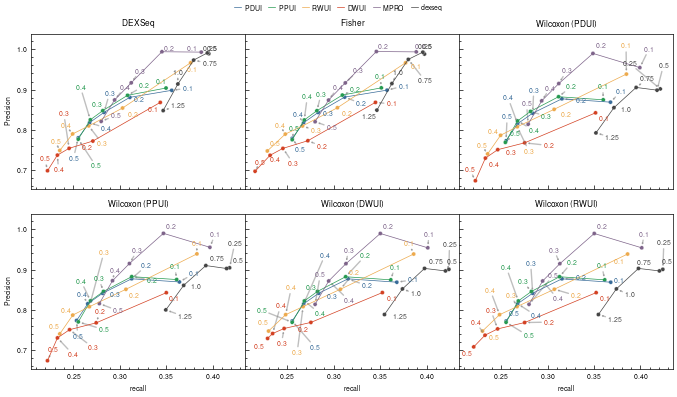

In [11]:
plt.close()
fig, axs = plt.subplots(2,3, figsize=(175*mm,100*mm),sharey=True, sharex=True)
filter_type_order = ['PDUI', 'PPUI', 'RWUI', 'DWUI', 'MPRO', 'dexseq']
stat_test_order = [
    'dexseq_0.05',
    'fisher_0.05',
    'wilcox_PDUI_0.05',
    'wilcox_PPUI_0.05',
    'wilcox_DWUI_0.05',
    'wilcox_RWUI_0.05'
    ]

stat_test_order_map = {
    'dexseq_0.05': 'DEXSeq',
    'fisher_0.05': 'Fisher',
    'wilcox_DWUI_0.05': 'Wilcoxon (DWUI)',
    'wilcox_PDUI_0.05': 'Wilcoxon (PDUI)',
    'wilcox_PPUI_0.05': 'Wilcoxon (PPUI)',
    'wilcox_RWUI_0.05': 'Wilcoxon (RWUI)'

}
data = de_performance_df[de_performance_df["filter_type_1"].str.endswith("0.05")].groupby(["filter_type","filter_value", "filter_type_1"]).mean(numeric_only=True).reset_index()
for i, stat_test_type in enumerate(stat_test_order):
    x = i // 3
    y = i % 3
    ax = axs[x,y]
    sns.lineplot(
        data[data["filter_type_1"] == stat_test_type],
        y="precision",
        x="recall",
        hue="filter_type",
        hue_order=filter_type_order,
        ax=ax,
        palette=palette,
    )
    ax.set_title(stat_test_order_map[stat_test_type], fontsize=6)

    sns.scatterplot(
        data[data["filter_type_1"] == stat_test_type],
        y="precision",
        x="recall",
        hue="filter_type",
        hue_order=filter_type_order,
        ax=ax,
        palette=palette,
        legend=False
    )
    texts = []
    for idx, row in data[data["filter_type_1"] == stat_test_type].iterrows():
        filter_type = row['filter_type']
        filter_value = row['filter_value']
        recall = row['recall']
        precision = row['precision']
        t = ax.text(recall, precision, filter_value, fontsize=5, ha='left', va='bottom', color=palette[filter_type_order.index(filter_type)])
        texts.append(t)
    
    adjust_text(texts, ax=ax, 
        x=data[data["filter_type_1"] == stat_test_type]["recall"],
        y=data[data["filter_type_1"] == stat_test_type]["precision"], 
        force_static=(0.5,1),
        expand=(1.2, 2), arrowprops=dict(arrowstyle='->', color='gray', alpha=.5),
        time_lim=5
        )
        
    # ax.set_xlim(ax.get_xlim()[0]-0.03, ax.get_xlim()[1]+0.03)
    ax.set_ylim(ax.get_ylim()[0]-0.005, ax.get_ylim()[1]+0.005)
    ax.set_yticks([0.7,0.8,0.9,1])
    ax.tick_params(which='minor', bottom=True)

    if y == 0:
        ax.set_ylabel("Precision")
    else:
        ax.set_ylabel("")
    # if y == 0:
    #     ax.set_xlabel("Recall")
    # if (x == 2) and (y == 1):
    # if (i == 5):
    #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # else:
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.subplots_adjust(wspace=0.001,)

plt.show()
plt.savefig('/root/apabenchmark/plot/fig4/de_apa_precision_recall.pdf', bbox_inches='tight', dpi=300)

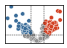

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 生成伪数据
n_genes = 1000
n_samples = 6
control = pd.DataFrame(np.random.normal(10, 1, (n_genes, n_samples)),
                       columns=[f'sample_{i}' for i in range(n_samples)],
                       index=[f'gene_{i}' for i in range(n_genes)])
treatment = pd.DataFrame(np.random.normal(10, 1, (n_genes, n_samples)),
                         columns=[f'sample_{i}' for i in range(n_samples)],
                         index=[f'gene_{i}' for i in range(n_genes)])

# 随机选择一些基因在实验组中上调或下调
up_genes = np.random.choice(control.index, 50, replace=False)
down_genes = np.random.choice(control.index, 50, replace=False)
treatment.loc[up_genes] += np.random.normal(1, 1, (50, n_samples))
treatment.loc[down_genes] -= np.random.normal(1, 1, (50, n_samples))

# 计算每个基因的log2FC和p值
log2FC = np.log2(treatment.mean(axis=1) / control.mean(axis=1))
p_values = pd.Series([ttest_ind(control.loc[gene], treatment.loc[gene])[1] for gene in control.index], index=control.index)

# 创建结果数据框
df = pd.DataFrame({'log2FC': log2FC, 'p_value': p_values}, index=control.index)

# 计算-log10(p_value)
df['-log10(p_value)'] = -np.log10(df['p_value'])

# 设置颜色阈值
df['color'] = np.where((df['log2FC'] > 0.1) & (df['-log10(p_value)'] > -np.log10(0.2)), 'red',
                np.where((df['log2FC'] < -0.1) & (df['-log10(p_value)'] > -np.log10(0.2)), 'blue', 'gray'))

# 绘制火山图
plt.figure(figsize=(20*mm, 15*mm))
sns.scatterplot(data=df, x='log2FC', y='-log10(p_value)', hue='color', 
                palette={'red': palette[3], 'blue': palette[0], 'gray': palette[6]},
                legend=False)

# 添加参考线
plt.axhline(y=-np.log10(0.2), color='black', linestyle='--', linewidth=0.3)
plt.axvline(x=-0.1, color='black', linestyle='--', linewidth=0.3)
plt.axvline(x=0.1, color='black', linestyle='--', linewidth=0.3)
plt.yticks([])
plt.xticks([])
plt.ylabel("")
plt.xlabel("")
# 添加标题和坐标轴标签

# 显示图形
plt.tight_layout()
plt.show()
plt.savefig('/root/apabenchmark/plot/fig1/de_apa_volcano.pdf', bbox_inches='tight', dpi=300)